<span style="color:#A00;font-weight:bold">Missing data: this notebook relies on KAST data. The files are not provided.</span>

## Single slit spectroscopy

*Single slit spectrum reduction, total linear regression, chi-squared space, residuals statistics*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

%matplotlib inline

This notebook addresses two primary challenges that typically stand in the way of completing this lab:

* Reduction of raw data from the KAST spectrograph, yielding a form similar to that produced by the Ocean Optics spectrometer. This is to allow previously written wavelength calibration code to be reused here.
* Implementation of a custom least squares routine to be used for the aforementioned wavelength calibration.

Both tasks heavily rely on techniques already covered in the course. Namely, the procedure of KAST data reduction is very similar to Nickel data reduction that was carried out in the first lab, while closed algebraic formulae for least squares fits have been derived in lectures.

As such, this notebook will not follow the style of previous computing sessions, where step-by-step instructions were given. Instead, it will merely summarize potential complications that the students are unlikely to have encountered before. These complications will be presented in no particular order.

## KAST FITS headers

The structure of FITS headers in the KAST dataset is somewhat heterogeneous and a little more challenging to parse automatically than it was for Nickel. To see this, iterate over every FITS file in the dataset and load the four most important headers: `OBJECT`, `EXPTIME`, `OBSTYPE`, `DSENSOR`. The last one contains an identifier of the CCD used.

<br>
<div class="alert alert-warning">
    Despite <a href="http://fits.gsfc.nasa.gov">considerable effort</a> invested in maintaining a single standard for FITS headers, virtually every telescope system uses slightly different conventions. Therefore, one should always display all FITS headers when analyzing a new dataset and familiarize oneself with the information available and its organization. This section is nothing more than my attempt at understanding FITS headers as used by KAST. It is definitely possible that the data shows more organization than I was able to find, which is why you are encouraged to print all headers out yourselves and look for a better way of handling the data.
</div>

In [2]:
data_dir = '../../KAST_spectra/'                    # Point this to YOUR KAST data repository
data_files = np.array(os.listdir(data_dir))

exposures = []
objects = []
frame_types = []
ccds = []

for data_file in data_files:
    h = fits.open(data_dir + data_file)
    objects       += [h[0].header['OBJECT']]
    exposures     += [h[0].header['EXPTIME']]
    frame_types   += [h[0].header['OBSTYPE']]
    ccds          += [h[0].header['DSENSOR']]
    h.close()

objects = np.array(objects)
frame_types = np.array(frame_types)
exposures = np.array(exposures).astype(float)
ccds = np.array(ccds)
    
# Print everything out. Typecasting the arrays into sets before printing will remove any duplicating
# elements. Sets are a special type in Python that are similar to lists, but do not have any particular
# order of elements or defined indices.
print "OBJECT:", set(objects)
print "OBSTYPE:", set(frame_types)
print "EXPTIME:", set(exposures)
print "DSENSOR:", set(ccds)

print data_files[objects == "neon"]

OBJECT: set(['dome flat', 'DomeFlat 4arcsec slit', 'PGC124', 'arc', 'DomeFlat 2arcsec slit', 'neon', 'Feige 110', '3C079', 'dark', 'B0026+129', 'bias', 'J0047+0319', 'BD+15233', 'Zw 229-015', 'Arc He, HgCd, Spare_Ar', 'Arc He, Hg-Ar, Neon', 'BD+284211'])
OBSTYPE: set(['DARK', 'OBJECT'])
EXPTIME: set([0.0, 1.0, 3.0, 5.0, 40.0, 300.0, 1200.0, 20.0, 120.0, 90.0, 60.0, 30.0])
DSENSOR: set(['Fairchild CCD 3041 2Kx2K', 'Ret 400x1200'])
['r3.fits']


Addressing the elephant in the room first, we have data coming from two different CCDs (`Fairchild CCD 3041 2Kx2K` and `Ret 400x1200`). These sensors may have different dimensions and readout schemes. In this notebook, I will entirely focus on the former sensor, leaving it up to the students to extend the procedure to the latter.

According to the observing log, we expect the dataset to contain the following frame types:

* Science frames. Those are spectra of stars (e.g. "BD+15233" you can see above) or galaxies (e.g. "3C079"). To find out more about these objects, visit [Simbad](http://simbad.u-strasbg.fr/simbad/sim-fbasic) - the online astronomical database - and search by their name.
* Arc frames. Those are spectra of discharge arc lamps that we can use to wavelength-calibrate the data. In the output above, you should see neon, helium and more. The [KAST website](https://mthamilton.ucolick.org/techdocs/instruments/kast/kast_arcSpectra.html) may be a good resource when it comes to identifying specific emission lines in these frames.
* Dark frames. Those are given away by the `OBSTYPE` header that is now saved in `frame_types`.
* Bias frames. Those are given away by the exposure time of $0$.
* Flat fields. Some of those are marked with `dome flat`; others have more complicated values of the `OBJECT` header, but the word `flat` is present in all their `OBJECT` records in one way or another.

To sort all frames automatically, we will have to use string operations. Two functions from NumPy are especially relevant:

* `np.char.lower()` takes an array of strings and transposes them all to lowercase.
* `np.char.count()` takes an array of strings and counts occurrences of a given substring in each element of the array.

In [3]:
# I only want the first of the two sensors
if (len(ccds == ccds[0]) == len(data_files)):   # This check is to make sure this snippet of code only runs once (TYPE HERE)
    data_files = data_files[ccds == ccds[0]]
    objects = objects[ccds == ccds[0]]
    frame_types = frame_types[ccds == ccds[0]]
    exposures = exposures[ccds == ccds[0]]

# First, let's get a taste for NumPy string operations
print np.char.lower('domeFlat')                          # Prints "domeflat" (all lowercase)
print np.char.count('dome', 'flat')                      # Prints "0" (no occurrences of flat found)
print np.char.count('domeflat', 'flat')                  # Prints "1" (one occurrence found)
print np.char.count('domeflatflat', 'flat')              # Prints "2"
print np.char.count('domeFlat', 'flat')                  # Prints "0" because the case does not match
print np.char.count(np.char.lower('domeFlat'), 'flat')   # Prints "1" despite the mismatching case

# Because this is NumPy, all operations can be iterated through arrays automatically
test_array = np.array(["domeFlat", "dome flat", "galaxy"])

# Which of those are flats?
print np.char.count(np.char.lower(test_array), 'flat') > 0   # Prints [True True False]

# Now onto sorting our FITS
biases = (exposures == 0.0)
darks = (frame_types == 'DARK')
flats = (np.char.count(np.char.lower(objects), 'flat') > 0)

# Everything that remains are light frames (either science or arcs)
# Remember that "~" is equivalent to np.logical_not() and "|" is equivalent to np.logical_or()
lights = ~(flats | darks | biases)

print "-------"
print "Lights:", data_files[lights]
print "Biases:", data_files[biases]
print "Darks:", data_files[darks]
print "Flats:", data_files[flats]

domeflat
0
1
2
0
1
[ True  True False]
-------
Lights: ['b100.fits' 'b151.fits' 'b152.fits' 'b153.fits' 'b154.fits' 'b155.fits'
 'b156.fits' 'b157.fits' 'b158.fits' 'b159.fits' 'b160.fits']
Biases: ['b101.fits' 'b102.fits' 'b103.fits' 'b104.fits' 'b105.fits' 'b106.fits'
 'b107.fits' 'b108.fits' 'b109.fits' 'b110.fits']
Darks: ['b101.fits' 'b102.fits' 'b103.fits' 'b104.fits' 'b105.fits' 'b106.fits'
 'b107.fits' 'b108.fits' 'b109.fits' 'b110.fits']
Flats: ['b111.fits' 'b112.fits' 'b113.fits' 'b114.fits' 'b115.fits' 'b116.fits'
 'b117.fits' 'b118.fits' 'b119.fits' 'b120.fits' 'b121.fits' 'b122.fits'
 'b123.fits' 'b124.fits' 'b125.fits' 'b126.fits' 'b127.fits' 'b128.fits'
 'b129.fits' 'b130.fits' 'b131.fits' 'b132.fits' 'b133.fits' 'b134.fits'
 'b135.fits' 'b136.fits' 'b137.fits' 'b138.fits' 'b139.fits' 'b140.fits'
 'b141.fits' 'b142.fits' 'b143.fits' 'b144.fits' 'b145.fits' 'b146.fits'
 'b147.fits' 'b148.fits' 'b149.fits' 'b150.fits']


## Overscan regions

There is a number of crucial differences between the KAST CCD and the Nickel CCD. The most prominent one can be seen by opening a bias frame and displaying it on the screen.

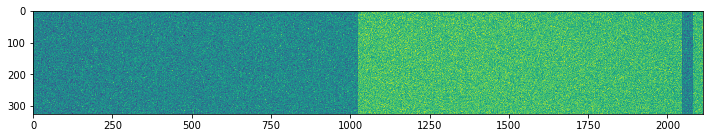

In [4]:
h = fits.open(data_dir + data_files[biases][0])  # First bias
data = h[0].data * 1.0                           # Remember to typecast to float
h.close()

plt.figure(figsize = [12, 9])                    # This will increase the image size to 12 inches across
                                                 # (technically, also 9 inches high, but the aspect ratio
                                                 #  will be automatically preserved)
plt.imshow(data)

It can hopefully be seen that the detector has two very distinct levels of bias in different regions. This is likely indicative of two independent readouts happening simultaneously. Perhaps, the pixels in the right half of the image are read out off the right edge of the CCD and the pixels in the left half are read out off the left edge of the CCD. If so, we would expect there to be two amplifiers per each row of pixels, which can be verified by looking at FITS headers:

In [5]:
h = fits.open(data_dir + data_files[biases][0])
print 'Amplifiers per row:', h[0].header["AMPSROW"]
print 'Amplifiers per column:', h[0].header["AMPSCOL"]
h.close()

Amplifiers per row: 2
Amplifiers per column: 1


You may also notice that something strange is happening near the right edge of the image. Those two stripes of bias, each approximately 30 pixels wide, is the so called *overscan* region. These pixels are never exposed to light (in fact, there may not be any "physical" pixels present on the CCD as such) and only record the bias level. We are getting two stripes for the two readouts that this CCD performs. The fact that these pixels are not exposed to light can be made more obvious by looking at a flat field:

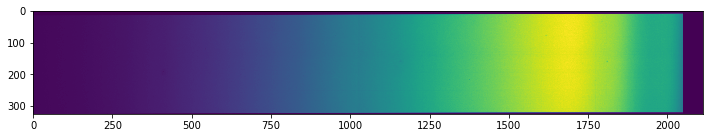

In [6]:
h = fits.open(data_dir + data_files[flats][0])  # First flat
data = h[0].data * 1.0
h.close()
plt.figure(figsize = [12, 9])
plt.imshow(data)

Although the overscan region may be useful in some applications, it will be our enemy in this experiment, as it may offset the statistics of the spectrum. In addition to the number of amplifiers, the FITS headers also store the number of overscan rows / columns per readout. We can use this information to slice the overscan region out:

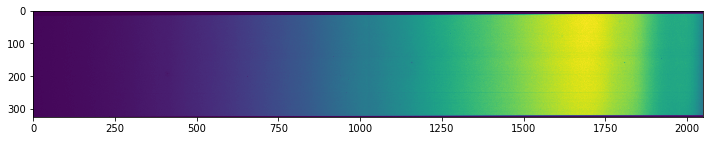

In [7]:
def load_frame(filename):
    """ Loads a KAST FITS file and removes the overscan region """
    h = fits.open(data_dir + filename)
    data = h[0].data * 1.0
    
    # Obtain the number of amplifiers
    ramps = int(h[0].header["AMPSROW"])
    camps = int(h[0].header["AMPSCOL"])
    
    # Obtain the number of overscan rows / columns
    cover = int(h[0].header["COVER"]) 
    rover = int(h[0].header["ROVER"]) 
    
    height, width = np.shape(data)
    
    # Slice the image
    data = data[:height - rover * camps, :width - cover * ramps]
    
    h.close()
    return data

plt.figure(figsize = [12, 9])
plt.imshow(load_frame(data_files[flats][10]))

## Spectrum extraction

Before the KAST spectra can be calibrated, they need to be reduced from two dimensions down to one dimension, just like the Ocean Optics spectra were. To proceed, let's take a random science spectrum, reduce it and see what it looks like:

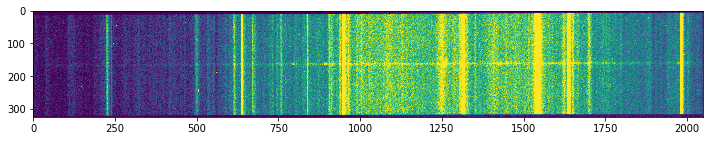

In [8]:
# First, obtain a master bias and flat.
# Strictly speaking, we should be including dark frames in our reduction too, but
# given the cooling of the CCD, it is ok to ignore dark currents in this lab

def compute_master_frame(data_files):
    """ I need a docstring! """
    master = None                   # None is a special value that indicates that the variable exists, but
                                    # does not store anything just yet
    for data_file in data_files:
        single = load_frame(data_file)
        if master is None:          # "is" checks if the variable belongs to a specific data type
                                    # I use it instead of "==", because Python does not like arrays
                                    # and individual values being compared.
            master = single
        else:
            master += single
    
    master /= len(data_files)
    
    return master

master_bias = compute_master_frame(data_files[biases])
master_flat = compute_master_frame(data_files[flats])


# Now I will load a random science frame. My choice is 3C079 - a galaxy
science = load_frame(data_files[objects == '3C079'][0])

###
# You will need to reduce your science frame here. Write code that computes the normalized
# flat field and corrects the science frame for it. Refer to lecture notes if in doubt
###

plt.figure(figsize = [12, 9])
mean = np.mean(science)
std = np.std(science)
plt.imshow(science, vmin = mean - std, vmax = mean + std)

<br>
<div class="alert alert-warning">
    In the code cell above, I use the mean statistic to compute the master frames. Can this reduction be more accurate if I used median instead? Under what circumstances does the median represent the average better than the mean?
</div>

Remember that the object (in my case, a galaxy) will only occupy a small fraction of the slit. This means that most of the frame is not the spectrum of the object itself, but the spectrum of the sky instead. This particular spectrum is so dim that the sky lines have a comparable brightness to that of the object's spectrum, which appears as a thin horizontal line in the middle of the frame. To extract this spectrum, we need to know where it begins and ends. Let us compute the average of every row of pixels to see if the rows containing the object's spectrum stand out:

Text(0,0.5,'Average signal')

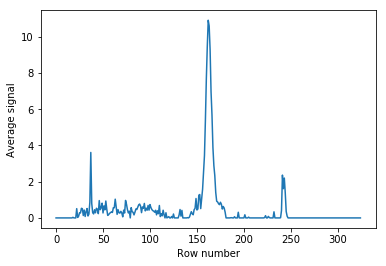

In [9]:
row_averages = np.mean(science, axis = 1)   # axis = 1 means "average rows only"
row_averages -= np.median(row_averages)     # Subtract any unwanted background
row_averages[row_averages < 0] = 0          # Kill all values rendered negative by the background subtraction

row_indices = np.array(range(len(row_averages)))      # Give our rows sequential indices

plt.plot(row_indices, row_averages)
plt.xlabel("Row number")
plt.ylabel("Average signal")

Hopefully, it is now very obvious where the object spectrum lies. We can find the minimum and the maximum row numbers using the same technique as we used to estimate left and right edges of emission lines:

(100, 200)

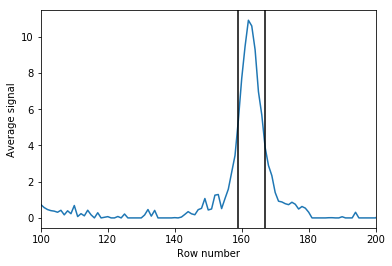

In [10]:
maximum_position = row_indices[max(row_averages) == row_averages]
half_maximum = max(row_averages) / 2

outside = row_averages < half_maximum



first_row = max(row_indices[outside & (row_indices < maximum_position)])
last_row  = min(row_indices[outside & (row_indices > maximum_position)])

plt.plot(row_indices, row_averages)
plt.xlabel("Row number")
plt.ylabel("Average signal")
plt.axvline(x = first_row, color = 'k')
plt.axvline(x = last_row, color = 'k')
plt.xlim(100, 200)

Finally, to obtain the spectrum, we will again average the data between the first row and the last row just determined. However, this time we will compute the average per column and not per row:

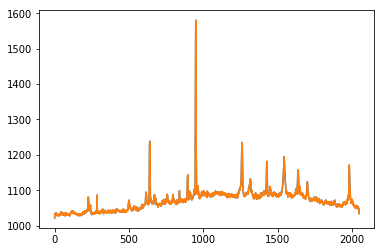

In [11]:
spectrum = np.mean(science[first_row:last_row], axis = 0)   # axis = 1 means "average columns only"
pixel_positions = range(len(spectrum))

plt.plot(spectrum)

# You may now want to save this spectrum in a text file and feed it into your calibration code...
output = np.array([spectrum, pixel_positions]).T            # .T swaps columns and rows around. This is
                                                            # the format that np.savetxt() expects

np.savetxt('3C079.spec', output, header = "Spectrum of 3C079, uncalibrated")

plt.plot(spectrum)

<br>
<div class="alert alert-warning">
    Strictly speaking, we are saving both the science spectrum and the sky spectrum superimposed on top of each other. Although not a strict requirement of this lab, you are encouraged to sample the sky spectrum by averaging rows away from the object's spectrum and correct the science spectrum by the sky spectrum.
</div>

For completness, let's have a look at a random arc spectrum in the data as well:

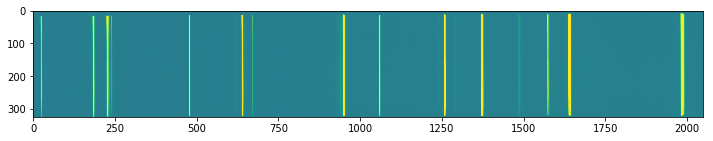

In [12]:
arc = load_frame(data_files[objects == 'Arc He, HgCd, Spare_Ar'][0])

###
# You will need to reduce your arc frame here. Write code that computes the normalized
# flat field and corrects the arc frame for it. Refer to lecture notes if in doubt
###

plt.figure(figsize = [12, 9])
mean = np.mean(arc)
std = np.std(arc)
plt.imshow(arc, vmin = mean - std, vmax = mean + std)

The arc spectrum fills up the entire slit and, hence, every row of pixels. However, the precise alignment of the slit may mismatch the axes of the sensor, which means that your wavelength calibration will be most reliable if you sample the arc spectrum across the same rows as your science spectrum. This is especially important if high-precision wavelength calibration is required. For a high quality spectrum, it is sometimes possible to estimate centroids down to $1/50$ of the pixel size! In this case, an offset even by one pixel would have disastrous consequences.

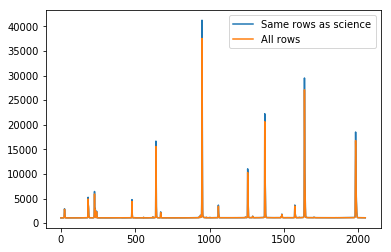

In [13]:
arc_spectrum_partial = np.mean(arc[first_row:last_row], axis = 0)  # This is what you should use
arc_spectrum_full = np.mean(arc, axis = 0)                         # For comparison


plt.plot(arc_spectrum_partial, label = "Same rows as science")
plt.plot(arc_spectrum_full, label = "All rows")
plt.legend()

## Further model fitting ##

Previously in this course, we often used built-in NumPy routines such as `np.polyfit()` to fit polynomial models to our data. In this lab, we use model fitting to wavelength-calibrate the spectrometer or, in other words, to convert the pixel positions of recorded spectral features into wavelengths. Mathematically, the fitting problem can be stated as follows:

We are presented with a set of data points: $x_i$ and $y_i$, where $x_i$ represents the independent variable and $y_i$ represents the dependent one. For one reason or another, we believe that $y_i$ must be related to $x_i$ via some mathematical function $f(x)$. In addition to $x$, $f(x)$ usually depends on a number of constants, whose values we do not know. For example, for a parabolic (second order polynomial) fit, $f(x)$ may look as follows:

$$f(x)=a\ x^2+b\ x+c$$

Here, $a$, $b$ and $c$ are the constants we do not know. Our aim is to determine the values of those constants (aka best-fit parameters).

To achieve this aim, we first need to a way to quantify how well the model approximates the data, given a set of best-fit parameters. I.e., when presented with two different sets of values for $a$, $b$ and $c$, we need an objective measure that will tell us which set is better suited to the data. For this, we need to introduce a so-called *goodness-of-fit* parameter. Throughout the history of statistics, [many ways](https://en.wikipedia.org/wiki/Goodness_of_fit) of defining this parameter have been proposed, each having its own strengths and weaknesses. The most popular definition and the one used in this course goes by the modest name $\chi^2$ (chi-squared). The definition can be written as follows:

$$\chi^2=\sum_{i}{(y_i-f(x_i))^2}$$

Geometrically, this is nothing more than the sum of squares of vertical distances between each data point and the model. $\chi^2$ is large when the fit is bad and small when the fit is good $\chi^2$. To determine the best-fit parameters, we need to understand how $\chi^2$ depends on them and then find such values of those parameters that $\chi^2$ is minimized.

The great advantage of polynomial models is that this minimization can be carried out **algebraically**. The lab script posted on TritonEd goes through the derivation of closed algebraic forms of parameters for first order polynomial models (straight line). You will need to implement those formulae in Python. Extending the same technique to higher order polynomials is only marginally harder once you have a sound understanding of a procedure. Furthermore, parabolic (second order) models are known to apply to diffraction-based spectrometers drastically better than first order models. As such, **you are highly encouraged** to implement and use higher order polynomial models in this lab.

This notebook will not contain any code, implementing the aforementioned algebra. Instead, the rest of the notebook will cover a few features of polynomial models that may be considered important. I will continue using built-in fitting routines such as `np.polyfit()` for demonstration only.

## Vertical distances VS orthogonal distances

Despite its incredible importance, this subtle quirk of model fitting is often overlooked. I will demonstrate it with a practical example. Let's create a test (synthetic) dataset that satisfies the following conditions:

* The underlying model is a straight line. I.e., without noise, the first order polynomial model would fit the dataset perfectly.
* The model shows a very steep rise (i.e., the slope of the straight line is very large).
* The dataset has large errors in both $x$ and $y$.

(-30, 130)

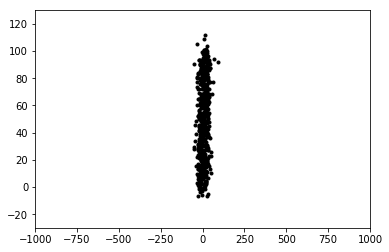

In [14]:
x = np.linspace(0, 10, 500)
y = 10 * x

# Add some random Gaussian noise
y += np.random.normal(0, 5, 500)
x += np.random.normal(0, 20, 500)

# Plot everything
plt.plot(x, y, 'k.')
plt.xlim(-1000, 1000)
plt.ylim(-30, 130)

Now, I will use `np.polyfit()` to fit a straight line model to this dataset. Hopefully, you will find the result somewhat surprising.

(-30, 130)

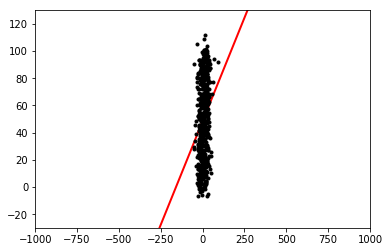

In [15]:
x_model = np.linspace(-1000, 1000, 1000)
y_model = np.poly1d(np.polyfit(x, y, 1))(x_model)

plt.plot(x_model, y_model, 'r-', lw = 2)
plt.plot(x, y, 'k.')
plt.xlim(-1000, 1000)
plt.ylim(-30, 130)

The reason why the fit clearly fails is hidden in the $\chi^2$ formula:

$$\chi^2=\sum_{i}{(y_i-f(x_i))^2}$$

Here, we are minimizing the sum of **vertical** distances between the model and the data. We do so, because this definition of $\chi^2$ was designed for situations, where $x$ is the independent variable, which means that:

* It is set by the experimenter.
* The uncertainty in its value is very small compared to the uncertainty in $y$.

Our synthetic dataset, however, defies this assumption by having $x$ errors exceed $y$ errors. To combat this issue, we need to redefine $\chi^2$ in terms of [orthogonal distances](https://en.wikipedia.org/wiki/Total_least_squares#/media/File:Total_least_squares.svg) instead. In this definition, the algebraic form of $\chi^2$ becomes virtually unmanageable. Fortunately, most distributions of Python come with a module called *SciPy* that contains a comprehensive suite of model fitting routines, including ones that consider orthogonal distances instead of vertical ones:

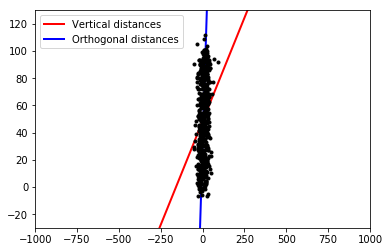

In [16]:
# Import the relevant functions from SciPy
from scipy.odr import Model, Data, ODR

# SciPy requires our model to be defined as a Python function
def model(best_fit, x):
    return (best_fit[0] * x) + best_fit[1]

# Use the imported functions from SciPy to obtain a fit
scipy_model = Model(model)
scipy_data  = Data(x, y)
regression = ODR(scipy_data, scipy_model, beta0 = [0, 1])
fit = list(regression.run().beta)

y_orthogonal = np.poly1d(fit)(x_model)

# Plot everything
plt.plot(x_model, y_model, 'r-', lw = 2, label = "Vertical distances")
plt.plot(x_model, y_orthogonal, 'b-', lw = 2, label = "Orthogonal distances")
plt.plot(x, y, 'k.')
plt.xlim(-1000, 1000)
plt.ylim(-30, 130)
plt.legend(loc = "best", fontsize = 10)

I have to admit that I picked an extreme example and most often the difference between the two definitions of $\chi^2$ is virtually non-existent. However, forgetting about this phenomenon may lead to frustrating mistakes when a high level of precision is required.

## Goodness of fit space

In this section, we will investigate how $\chi^2$ depends on the best-fit parameters as a function of noise. For simplicity, we will be considering a model of only one parameter:

$$y=ax$$

This time, let us generate a more "mundane" synthetic dataset for our experiments. I will keep things simple by setting $a=1$:

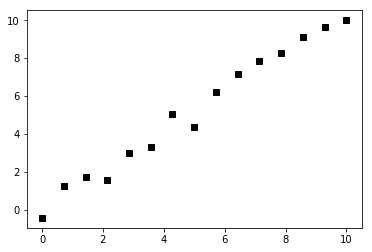

In [17]:
def generate_data(noise):
    """ Create a test synthetic dataset with a given y-uncertainty """
    x = np.linspace(0, 10, 15)
    y = 1 * x + np.random.normal(0, noise, 15)
    return x, y

x, y = generate_data(0.5)
plt.plot(x, y, 'ks')

Now, we will compute $\chi^2$ as a function of $a$:

In [18]:
def chi_squared(x, y, a):
    return np.sum((y - a * x) ** 2.0)

Finally, we plot out the $\chi^2$ space for different noise levels:

For the noise level of 0.0001, the best fit parameter(a) is 0.998998998998999
For the noise level of 0.2, the best fit parameter(a) is 0.988988988988989
For the noise level of 1.0, the best fit parameter(a) is 1.001001001001001
For the noise level of 3.0, the best fit parameter(a) is 0.974974974974975


Text(0,0.5,'Goodness-of-fit, $\\chi^2$')

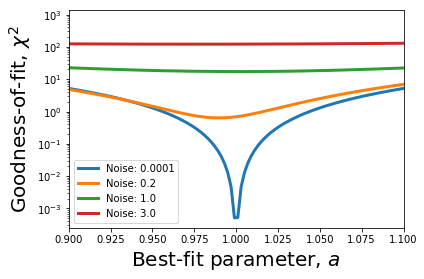

In [19]:
noises = [0.0001, 0.2, 1.0, 3.0]

for noise in noises:
    x, y = generate_data(noise)
    a_grid = np.linspace(0, 2, 1000)
    chi_squared_grid = np.zeros(len(a_grid))
    for i, value in enumerate(a_grid):
        chi_squared_grid[i] = chi_squared(x, y, value)
    plt.plot(a_grid, chi_squared_grid, label = "Noise: {}".format(str(noise)), lw = 3)
    best_fit = a_grid[chi_squared_grid == np.min(chi_squared_grid)][0]
    print "For the noise level of {}, the best fit parameter(a) is {}".format(str(noise), str(best_fit))

plt.yscale('log')
plt.xlim(0.9, 1.1)
plt.legend(loc = "lower left", fontsize = 10)
plt.xlabel("Best-fit parameter, $a$", size = 20)
plt.ylabel("Goodness-of-fit, $\chi^2$", size = 20)

To state the obvious, a better fit can be achieved when the noise level is low. This explains why low noise levels correspond to lower minimum $\chi^2$ values. Also worth noticing is the fact that the location of the minimum is much more obvious at low noise levels, while at high noise levels the curve is virtually flat. This indicates that the obtained value of the best-fit parameters is less certain when the fit is poor. More specifically, it is possible to estimate the uncertainty in the best fit parameters by looking at the slope, surrounding the minimum.

In real applications, there will often be more than just one best-fit parameter (even in the case of a proper straight line there will be two!), which will turn the plot above into a multidimensional landscape ($\chi^2$ space) with mountains representing bad fits and valleys representing good fits. Frequently, this landscape will not have a closed algebraic form and a computational approximation will be required.

A very basic computational minimization was actually demonstrated in the code cell above, employing the `np.min()` function. There are, however, much more precise and creative methods, some of which are animated in this insightful [blog post](https://www.benfrederickson.com/numerical-optimization/) by Ben Frederickson.

Once the minimum is found, the algorithm will need to perturb the values of the best-fit parameters to probe the "steepness" of the valley and, from there, estimate the covariance matrix of the fit.

## Residual subplots

The minimum $\chi^2$ value is indicative of the overall quality of the fit; however, it is often desired to know the contribution of every individual point, so that potential outliers could be spotted and excluded. Consider the following synthetic dataset:

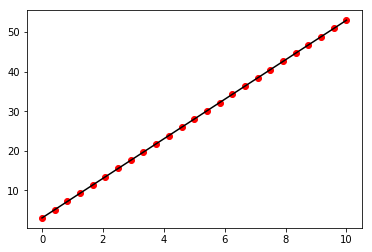

In [20]:
x = np.linspace(0, 10, 25)
y = 5 * x + 3

# Add some Gaussian noise in y
y += np.random.normal(0, 0.01, 25)
# Add some more noise to one of the data points, which will be our synthetic outlier
y[5] += np.random.normal(0, 0.1)

# Plot the data
plt.plot(x, y, 'ro')


# Plot a linear fit
y_model = np.poly1d(np.polyfit(x, y, 1))(x)
plt.plot(x, y_model, 'k-')

This dataset if of very high quality, which makes spotting the outlier a challenge. Now, let's add a plot of fit residuals:

Text(0,0.5,'Residual')

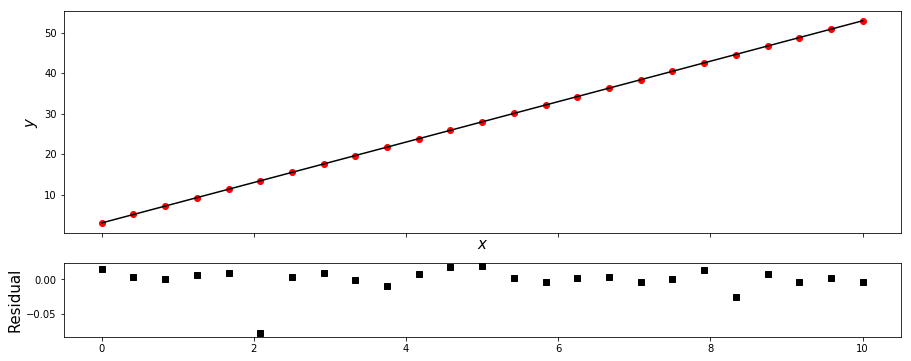

In [21]:
# We need to create two sets of axes. plt.subplots() can do that for us!
# The first argument is the number of rows and the second argument is the number of columns.
# I want to plot my residuals under the main plot, so I will need two rows and one column.
# "sharex = True" means "make my sets of axes share the same x-scale"
# gridspec_kw makes the upper plot 3 times larger
# figsize sets the size of the figure to 15x6 inches.
my_figure, axes = plt.subplots(2, 1, sharex = True, gridspec_kw = {'height_ratios': [3, 1]}, figsize = [15, 6])

# plt.subplots() returns an array, where each element represents a set of axes. First, set up the main plot:
axes[0].plot(x, y, 'ro')
axes[0].plot(x, y_model, 'k-')
axes[0].set_xlabel('$x$', size = 15)  # Notice, we use set_xlabel() instead of just xlabel()
axes[0].set_ylabel('$y$', size = 15)

# Now plot the residuals
axes[1].plot(x, y - y_model, 'ks')
axes[1].set_ylabel('Residual', size = 15)

<div class="alert alert-info">
    <i>MatPlotLib</i> supports two different *programming paradigms*: procedural and object-oriented. We have been mostly using the former until now, where we called special functions in the module to make things happen (for example, <code>plt.plot()</code> to make a plot, `plt.xlabel()` to add an axis label etc).
    <br><br>
    In this somewhat more advanced example, we are forced to use the object-oriented paradigm instead, where we create an axes object first and then call functions within that object (technically, <i>methods</i>) to manipulate it. Some of those methods have the same names and definitions as the corresponding functions (e.g. <code>plot()</code>); others are slightly different (e.g. <code>xlabel()</code> is now <code>set_xlabel()</code>).
    <br><br>
    The official documentation is your best beacon in navigating this land. You can find a complete list of methods of the <code>axes</code> object class <a href="https://matplotlib.org/api/axes_api.html">here</a> and a list of procedural MatPlotLib functions <a href="https://matplotlib.org/api/pyplot_summary.html">here</a> (in fact, it is the <i>PyPlot</i> submodule within MatPlotLib that introduces the procedural paradigm).
</div>

Residuals are not only useful for identifying outliers but also for determining if the chosen model is correct. If it is, the residuals should be purely random. Any patterns and structures displayed by the residuals subplot would be indicative of the model being incomplete. Consider the following example:

Text(0,0.5,'Residual')

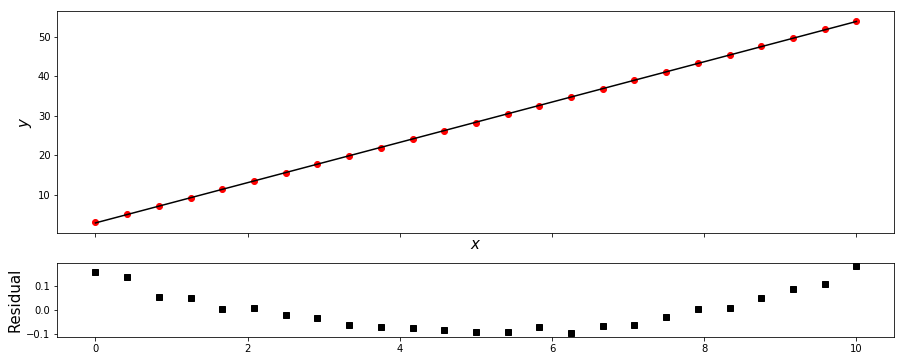

In [22]:
# This time, I want parabolic data (second order), but I will try and fit a straight line anyway
x = np.linspace(0, 10, 25)
y = 0.01 * x ** 2.0 + 5 * x + 3
y += np.random.normal(0, 0.01, 25)
y_model = np.poly1d(np.polyfit(x, y, 1))(x)

# Plot everything with residuals
my_figure, axes = plt.subplots(2, 1, sharex = True, gridspec_kw = {'height_ratios': [3, 1]}, figsize = [15, 6])
axes[0].plot(x, y, 'ro')
axes[0].plot(x, y_model, 'k-')
axes[0].set_xlabel('$x$', size = 15)
axes[0].set_ylabel('$y$', size = 15)
axes[1].plot(x, y - y_model, 'ks')
axes[1].set_ylabel('Residual', size = 15)

The main data plot hardly shows any deviations from the straight line and a first order polynomial may appear to be a suitable fit. Yet, the plot of residuals clearly suggests that there is more going on. And indeed there is: the underlying distribution of data is parabolic and not linear!